In [1]:
# Common stuff reused by all applications
from analysis_common import *
%matplotlib inline


EXPERIMENT_SIZE_FIELDS = [
    "number_of_fragments", 
    "points_per_fragment", 
]

PLATFORM_FIELDS = [
    "nodes",
    "cpus_per_node",
    "backends_per_node",
]

HANDPICKED_OUTLIERS = [
    23781312, 23781315, 23781286, 23781294, 23781297, 23747333, 
    23747318, 23748308,
    23781323, 23781301,
    23781369, 23903522,
    23903530,
    23903555, 23903557, 23903547, 23903543, 23903542, 23903531,
    23903573, 23903567
]

In [2]:
db = DataStorage("csvm-split")
df = prepare_df(db, HANDPICKED_OUTLIERS)

df.drop(df[(df['id'] < 28182707) & (df['dask'] == 1)].index, inplace=True)
df.drop(df[(df['id'] < 28231260) & (df['dask'] == 1) & (df["use_split"] == 1)].index, inplace=True)

In [3]:
edf = df.explode("execution_time").sort_values('mode')
edf['execution_time'] = edf['execution_time'].astype(float)

winsorize_edf(edf, "execution_time", ["mode", "nodes", "points_per_fragment", "number_of_fragments"])


/home/alex/BSC/split-miniapps/analysis/analysis_common.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df[mask] = mstats.winsorize(working_df[mask], limits=[0, 0.3])


# Weak scaling (small blocks)


/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


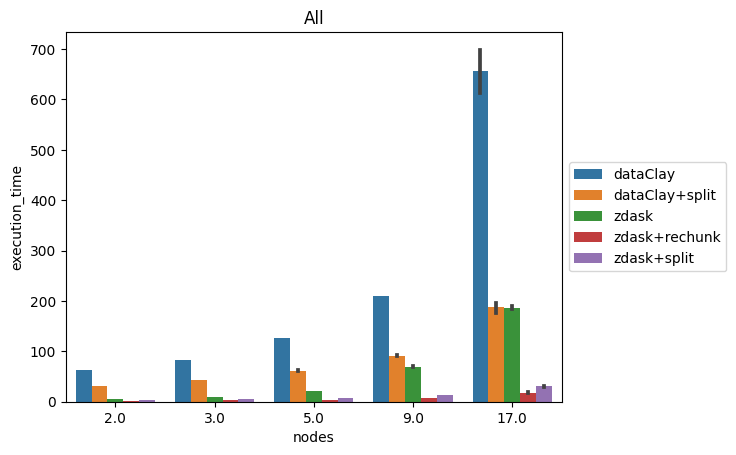

<Figure size 640x480 with 0 Axes>

/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


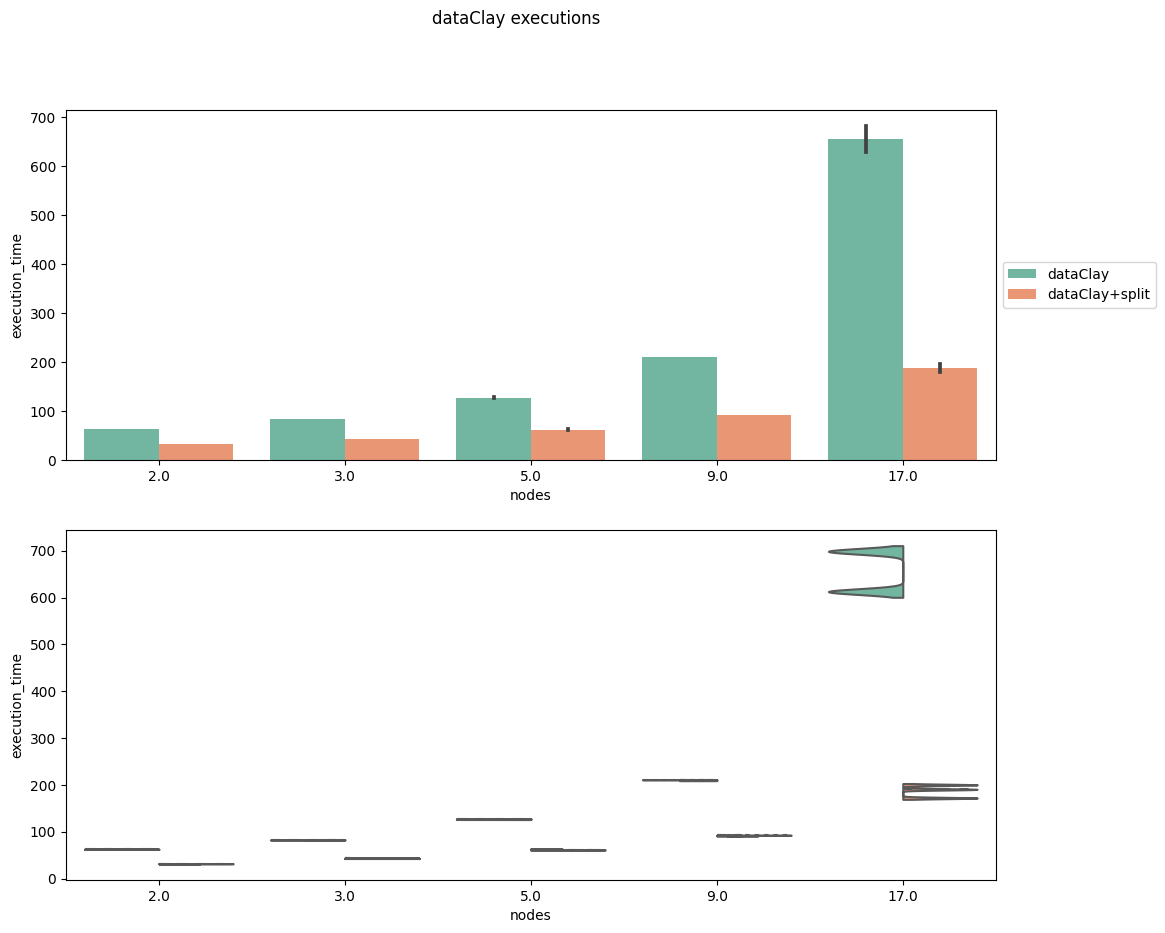

initialization_time  execution_time  split_overhead_time
nodes mode                                                                    
2.0   dataClay                  57.881934       62.312165             7.230713
      dataClay+split            57.359621       31.564803             6.656493
      zdask                      4.823169        5.363021                  NaN
      zdask+rechunk              5.041965        2.013664                  NaN
      zdask+split                5.139806        3.785589                  NaN
3.0   dataClay                  71.502003       82.481270             8.658333
      dataClay+split            73.412438       43.057921            12.211147
      zdask                      5.867632       10.306540                  NaN
      zdask+rechunk              5.860380        2.718521                  NaN
      zdask+split                6.155050        4.952941                  NaN
5.0   dataClay                 133.314067      126.758022            12.774601
      dataClay+split           132.817341       61.591841            20.135567
      zdask                      9.161694       21.875534                  NaN
      zdask+rechunk              9.220689        4.154901                  NaN
      zdask+split                9.160687        7.443326                  NaN
9.0   dataClay                 259.815981      210.167634            23.340494
      dataClay+split           259.047448       91.726434            39.412902
      zdask                     17.532150       69.692247                  NaN
      zdask+rechunk             17.551013        7.251548                  NaN
      zdask+split               17.558691       13.675925                  NaN
17.0  dataClay                 516.830511      655.687557            45.120938
      dataClay+split           516.683995      187.411669            68.110552
      zdask                     59.256449      186.559881                  NaN
      zdask+rechunk             58.960599       18.174658                  NaN
      zdask+split               58.991410       30.905697                  NaN

In [4]:
# Weak scaling
data = edf.query("((number_of_fragments / (nodes - 1)) == 384) and (points_per_fragment == 128)")
small_blocks_data = data.copy()
small_blocks_data["nodes"] -= 1

plot_things(data, "execution_time")

data = data.drop(data.columns.difference(["nodes", "mode", "execution_time","split_overhead_time", "initialization_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

## Weak scaling (big blocks)

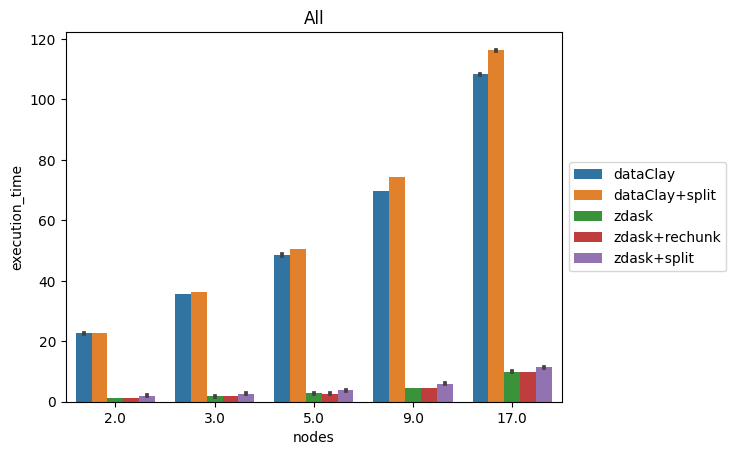

<Figure size 640x480 with 0 Axes>

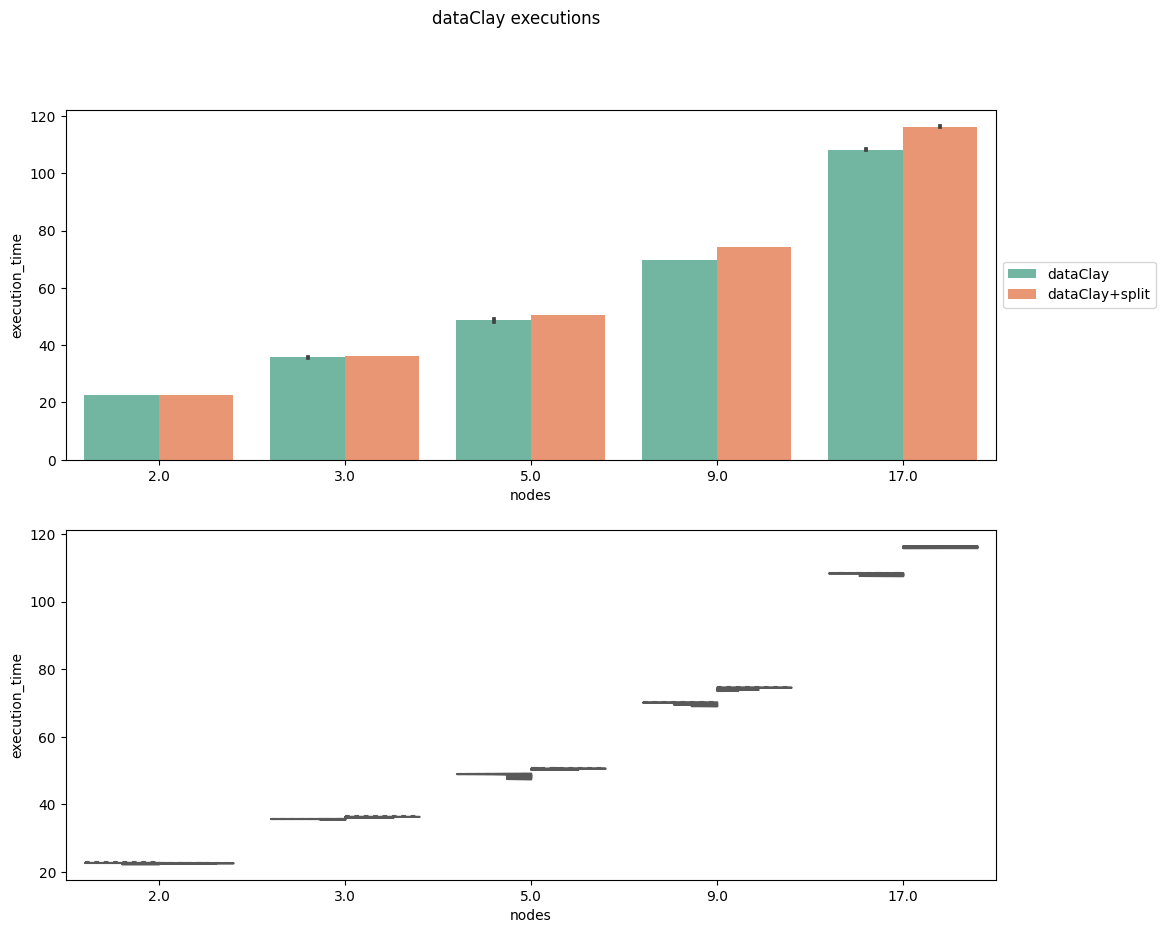

initialization_time  execution_time  split_overhead_time
nodes mode                                                                    
2.0   dataClay                  58.008320       22.612900             0.672494
      dataClay+split            57.814061       22.622404             1.890151
      zdask                      3.243405        1.358066                  NaN
      zdask+rechunk              3.229456        1.237816                  NaN
      zdask+split                3.392371        2.024707                  NaN
3.0   dataClay                  72.570946       35.724519             1.607289
      dataClay+split            72.453239       36.293306             3.853843
      zdask                      3.250090        1.770280                  NaN
      zdask+rechunk              3.303932        1.779373                  NaN
      zdask+split                3.510586        2.618149                  NaN
5.0   dataClay                 133.143819       48.615770             3.648488
      dataClay+split           133.167427       50.587769             8.499784
      zdask                      3.487617        2.720890                  NaN
      zdask+rechunk              3.625480        2.690166                  NaN
      zdask+split                3.588781        3.754030                  NaN
9.0   dataClay                 255.948848       69.849278             7.475863
      dataClay+split           256.803988       74.369155            17.338770
      zdask                      4.316869        4.557577                  NaN
      zdask+rechunk              4.339837        4.528811                  NaN
      zdask+split                4.098261        5.981342                  NaN
17.0  dataClay                 502.036298      108.274648             8.941590
      dataClay+split           502.784977      116.289553            30.531599
      zdask                      5.593087        9.973563                  NaN
      zdask+rechunk              5.662883        9.865627                  NaN
      zdask+split                5.358130       11.325170                  NaN

In [5]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("((number_of_fragments / (nodes - 1)) == 48) and ((points_per_fragment) == (128 * 8))")
big_blocks_data = data.copy()
big_blocks_data["nodes"] -= 1

plot_things(data, "execution_time")
plt.show()

data = data.drop(data.columns.difference(["nodes", "mode", "execution_time","split_overhead_time", "initialization_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

## Blocksize sweep


In [6]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("(nodes == 9) and ((number_of_fragments * points_per_fragment) == 393216)")

def eval_granularity_index(row):
    index = row["number_of_fragments"] // (48 * 8)
    row["granularity_index"] = index
    row["blocks_per_core"] = "%sx" % index
    return row

data = data.apply(eval_granularity_index, axis=1)
sweep_data = data.copy()

/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


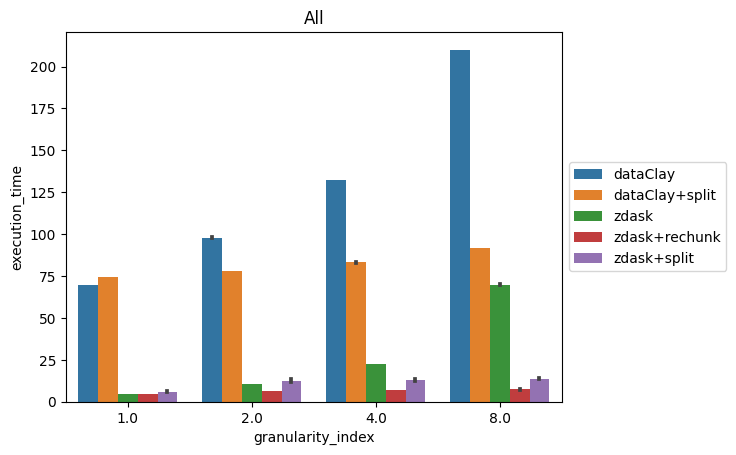

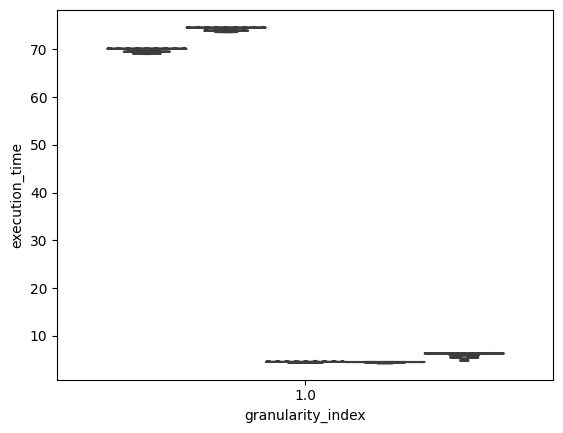

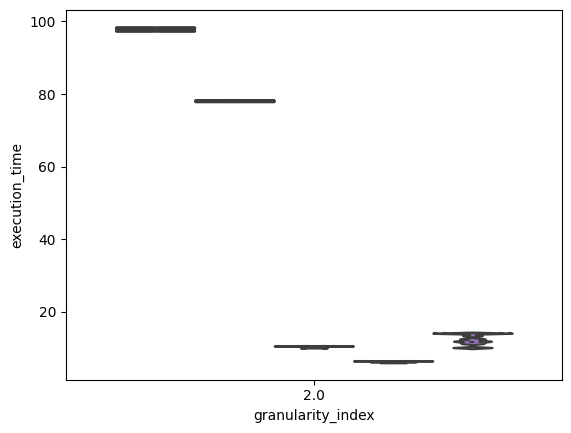

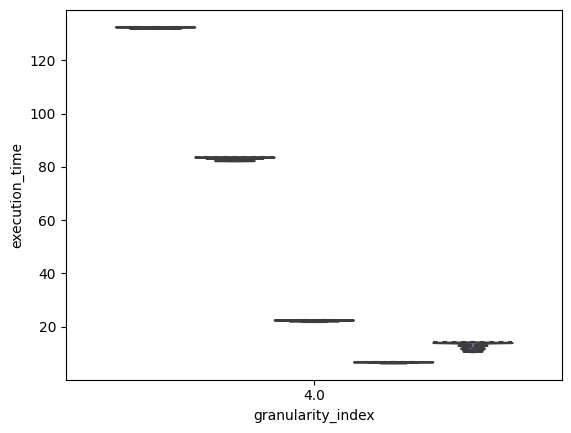

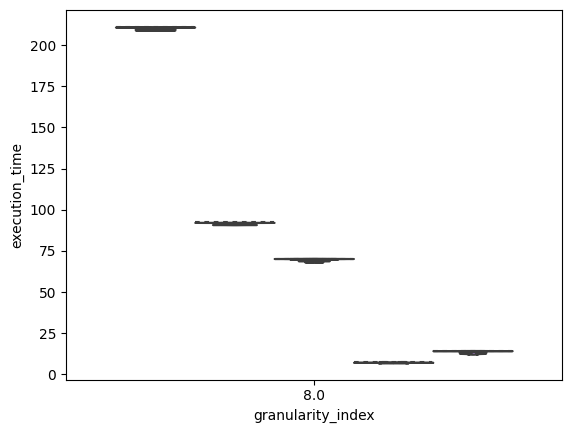

/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


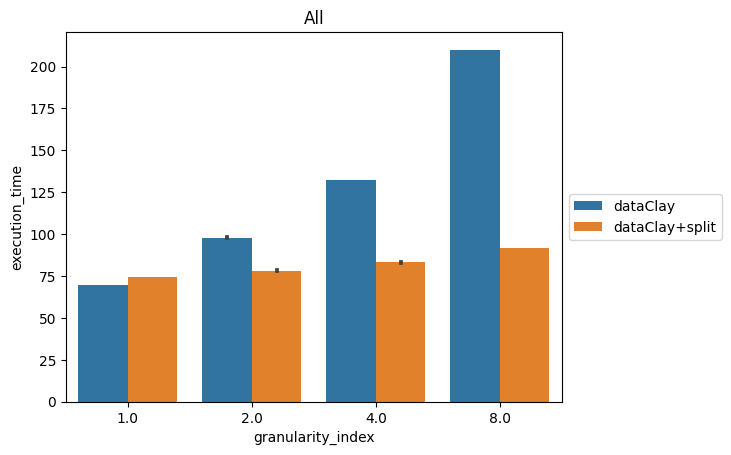

initialization_time  execution_time  \
granularity_index mode                                                  
1.0               dataClay                 255.948848       69.849278   
                  dataClay+split           256.803988       74.369155   
                  zdask                      4.316869        4.557577   
                  zdask+rechunk              4.339837        4.528811   
                  zdask+split                4.098261        5.981342   
2.0               dataClay                 256.773120       97.928545   
                  dataClay+split           259.203985       78.149015   
                  zdask                      5.434626       10.405924   
                  zdask+rechunk              5.522266        6.299090   
                  zdask+split                5.422168       12.456011   
4.0               dataClay                 254.953073      132.409171   
                  dataClay+split           257.923425       83.255689   
                  zdask                      8.970743       22.360654   
                  zdask+rechunk              8.997735        6.705890   
                  zdask+split                9.006379       12.955856   
8.0               dataClay                 259.815981      210.167634   
                  dataClay+split           259.047448       91.726434   
                  zdask                     17.532150       69.692247   
                  zdask+rechunk             17.551013        7.251548   
                  zdask+split               17.558691       13.675925   

                                  split_overhead_time  
granularity_index mode                                 
1.0               dataClay                   7.475863  
                  dataClay+split            17.338770  
                  zdask                           NaN  
                  zdask+rechunk                   NaN  
                  zdask+split                     NaN  
2.0               dataClay                   8.891128  
                  dataClay+split            20.472953  
                  zdask                           NaN  
                  zdask+rechunk                   NaN  
                  zdask+split                     NaN  
4.0               dataClay                  12.853371  
                  dataClay+split            26.057195  
                  zdask                           NaN  
                  zdask+rechunk                   NaN  
                  zdask+split                     NaN  
8.0               dataClay                  23.340494  
                  dataClay+split            39.412902  
                  zdask                           NaN  
                  zdask+rechunk                   NaN  
                  zdask+split                     NaN

In [7]:
sns.barplot(data=data, x="granularity_index", hue="mode", y="execution_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
# TODO: Change granularity_index to: fragments per core [o algo així]
plt.show()

for i in [1, 2, 4, 8]:
    ax = sns.violinplot(data=data.query("granularity_index == %d" % i),
                        x="granularity_index", hue="mode", y="execution_time", 
                        scale='width', bw=VIOLIN_BW,
                        inner="quartile", figsize=123)
    ax.get_legend().remove()
    plt.show()

sns.barplot(data=data.query("dataclay == 1"), x="granularity_index", hue="mode", y="execution_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
plt.show()

data = data.drop(data.columns.difference(["granularity_index", "mode", "execution_time","split_overhead_time", "initialization_time"]), axis="columns")
data.groupby(["granularity_index", "mode"]).mean()

# Figure generation

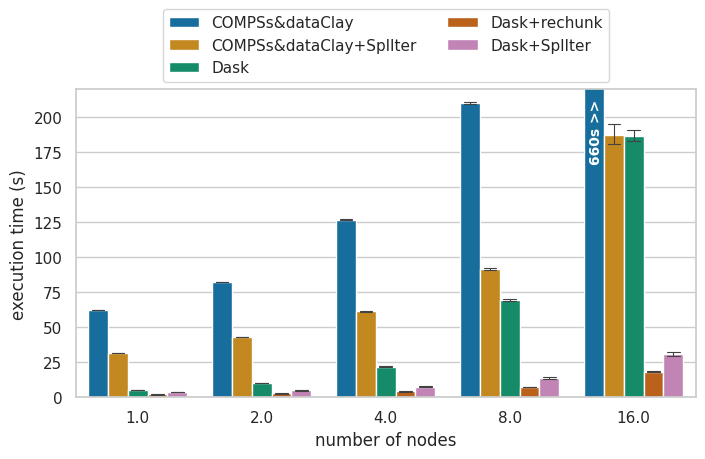

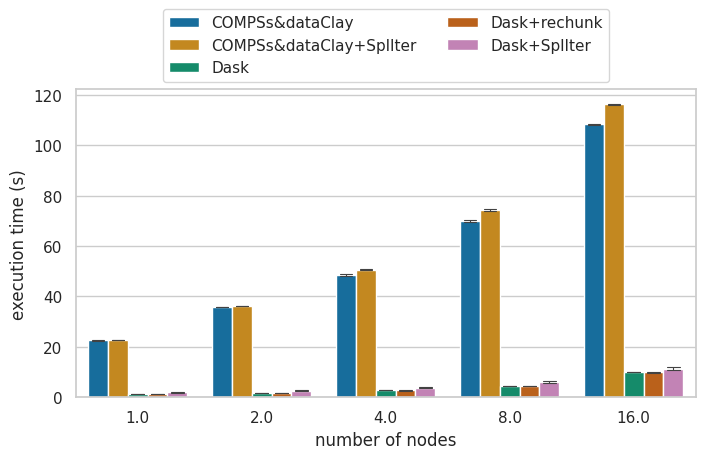

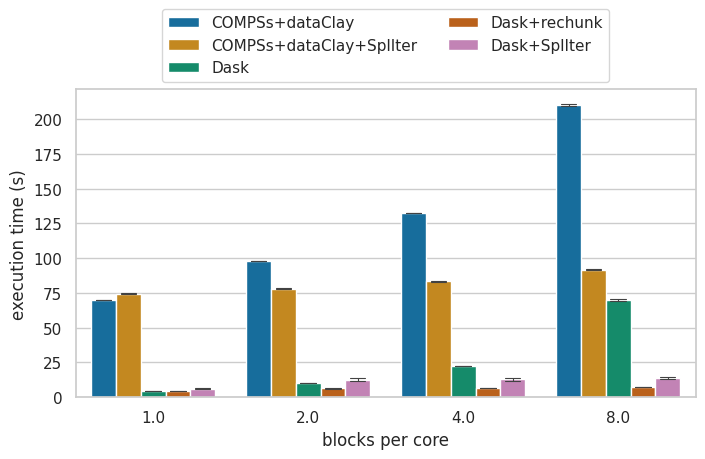

In [8]:
sns.set(style="whitegrid", color_codes=True)

hue_order=["dataClay", "dataClay+split", "zdask", "zdask+rechunk", "zdask+split"]

ax = sns.barplot(y="execution_time", x="nodes", hue="mode",
                 data=small_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 errorbar=("pi", 50),
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs&dataClay", "COMPSs&dataClay+SplIter", "Dask", "Dask+rechunk", "Dask+SplIter"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

ax.set_ylim([0, 220])
ax.text(3.70, 220, "660s >>  ", ha="center", va="top", rotation=90, color="white", weight="semibold", fontsize=10)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=True,
)

save_tweaks("csvm-weakscaling_smallblocks.pdf")
plt.show()

ax = sns.barplot(y="execution_time", x="nodes", hue="mode",
                 data=big_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 errorbar=("pi", 50),
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs&dataClay", "COMPSs&dataClay+SplIter", "Dask", "Dask+rechunk", "Dask+SplIter"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=True,
)

save_tweaks("csvm-weakscaling_bigblocks.pdf")
plt.show()

ax = sns.barplot(y="execution_time", x="granularity_index", hue="mode",
                 data=sweep_data,
                 capsize=0.1,
                 errwidth=0.8,
                 errorbar=("pi", 50),
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs+dataClay", "COMPSs+dataClay+SplIter", "Dask", "Dask+rechunk", "Dask+SplIter"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("blocks per core")

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=True,
)

save_tweaks("csvm-blocksweep.pdf")
plt.show()
